# Working with Complex and Scrace Datasets [Notebook 2]

## Introduction

When it comes to deep learning applications and its development, it is certain that Data is the most essential component of the process. By and of itself, the training data should flow into the networks unobstructed. It should contain meaningful and impactful information for the network/model. Prior to entering the network, the dataset should be prepared by various transformations and such. 

Today, datasets can be obtained from several complex structures or that are stored on heterogenous devices, this inherently also increases the complexity in its handling as well. While this assumes that the data is readily avaible, on the other hand, there cases where the relevant training data (images or annotations) can be unavailable or scarce. 

This project will venture into dealing with these kinds of cases where it also explores the framework that is available with TensorFlow to set up optimised data pipelines (tf.data API).


## Breakdown of this Project:
- Building efficient input pipelines with "tf.data" for extracting and processing data samples of all kinds. (Notebook 1 & 2)
- Augment and render images to help compensate for scarcity of training data. (Notebook 3 & 4)
- Different types of Doamin Adaptation methods and how it helps to train more robust models. (Notebook 5 & 6)
- Create or generate novel images with generative models such as Variational AutoEncoders (VAEs) and Generative Adversarial Networks (GANs). (Notebook 7 & 8)

## Requirements:
1. Vispy
2. Tensorflow 2.++
3. Numpy
4. OS

## Dataset:

The dataset can be obtain from the link: http://www.laurencemoroney.com/rock-paper-scissors-dataset/ or from https://www.tensorflow.org/datasets/catalog/rock_paper_scissors

Rock Paper Scissors is a dataset containing 2,892 images of different types of hands in Rock/Paper/Scissors poses that were 3D-rendered. Each of these images are 300×300 pixels in 24-bit colour.

In [1]:
import os
import tensorflow as tf
import numpy as np

# Run on GPU:
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 

# Set the random set seed number: for reproducibility.
Seed_nb = 42

# Set to run or not run the code block: for code examples only. (0 = run code, and 1 = dont run code)
dont_run = 0

## 1 - Generating and Parsing TFRecords:

As part of building an efficient input pipelines from the previous notebook. This notebook (2) will venture into __TFRecords__ where it is a format to persist datasets with TensorFlow. 

## 1.1 - Reminder of the ETL process:

##### The following diagram below demonstrates the overall ETL process for computer vision tasks:

<img src="Description Images/ETL_ComputerVision.png" width="750">

Image Ref -> self-made.

## 1.2 - About TFRecords: Transform by Parsing TFRecord Files

Recalling back from the previous notebook: A more efficient way of inputting the data into the pipeline would be using the "TFRecord" file format, where it will store large number of images together into a binary file and make them directly accessible for read-from-disk operations. This is because the process of iterating through the image files, by the methods mentioned in the above section, are inefficient. 

In more detail, TFRecord files are binary files where it will aggregate the data samples such as labels, images, and metadata. It can be serialised with a "tf.train.Example" instance, where it is a dictionaries that names each of the data elements (features). For example:
- {'img'; image1, 'label': label_1, ...}

Each of these element or feature that a sample contains would be an instance of "tf.train.Feature" or of its subclasses. These types of objects will be stored as lists of bytes, floats or integers.
To utilise TFRecord files as part of the input pipelines, the record/data can be passed with:
- tf.data.TFRecordDataset(filename)

More examples can be found in the lin: https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset.

## 2 - Writing TFRecords:

From the above section, it was mentioned that TFRecords files can be stored as one binary archive with the complete dataset for training, where in doing so, it can be efficiently be reused and iterated over. The following will demonstrate the use of "tf.data" and "tf.train" APIs to process a chosen dataset into a TFRecord file.

### 2.1 - Preparing the Dataset:

Here, the chosen dataset will be the __Rock-Paper-Scissors__ dataset from "tensorflow-datasets".

In [2]:
# Import the required library:
import tensorflow_datasets as tfds

In [3]:
# Load in the Dataset:
hands_builder = tfds.builder(name="rock_paper_scissors")
hands_builder.download_and_prepare()

# After the download, print out some information on the dataset:
print(hands_builder.info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



With the dataset downloaded, next is to instantiate it so that it can be process and later be converted to TFRecords.

In [4]:
# Instantiate the dataset:
hands_dataset = hands_builder.as_dataset(split=tfds.Split.TEST)

#### Assumption:

Here, the assumption is that this dataset will be prepared for the training purposes for several different models. These will classify the lower-quality rock/paper/scissors images (images are of 64 x 64 pixels). The goal is then to prepare a TFRecord file containing all of the image data of the lower pixel images. This also means that there will be some resizing beforehand.

### 2.2 - Resize the Images: from 300 x 300 pixels to 64 x 64 pixels.

In [5]:
# Define the desired image size: 
input_size = (64, 64)

In [8]:
# Define a function to resize the dataset images:
def prepareAndResize_sample(sample):
    """ This function will resize the dataset images to the specified size.
    Parameters:
        - sample, are the image samples to be converted.
    Returns:
        - returns the Resized dataset images.
    """
    # Resize:
    sample['image'] = tf.image.resize(images=sample['image'], size=input_size)
    
    # Since the above returns float values, these will have to be re-cast to uint8:
    sample['image'] = tf.cast(x=sample['image'], dtype=tf.uint8)
    
    return sample

In [9]:
# Apply the function for resizing:
hands_dataset = hands_dataset.map(prepareAndResize_sample)

# Print:
print(hands_dataset)

<MapDataset shapes: {image: (64, 64, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


### 2.3 - Optimise the Input Pipeline:

By manually setting the experimental optimisation options to improve the pipeline performance.

In [10]:
# Enable Prefetching:
hands_dataset = hands_dataset.prefetch(1)

# Enable Optimisation Options:
options = tf.data.Options()

options.experimental_optimization.map_fusion = True
options.experimental_optimization.map_parallelization = True
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_optimization.autotune = True

# Implement the dataset with the options:
hands_dataset = hands_dataset.with_options(options)

Now that some optimisations enabled and implemented, the next stage is to visualise the dataset.

### 2.4 - Visualise the Dataset:

In [11]:
# Import the required libraries:
from plotting_utilities import plot_images_inGrid

Image labels: ['rock' 'paper' 'rock' 'scissors' 'scissors' 'rock']


D:\anaconda3\envs\Py37Work\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


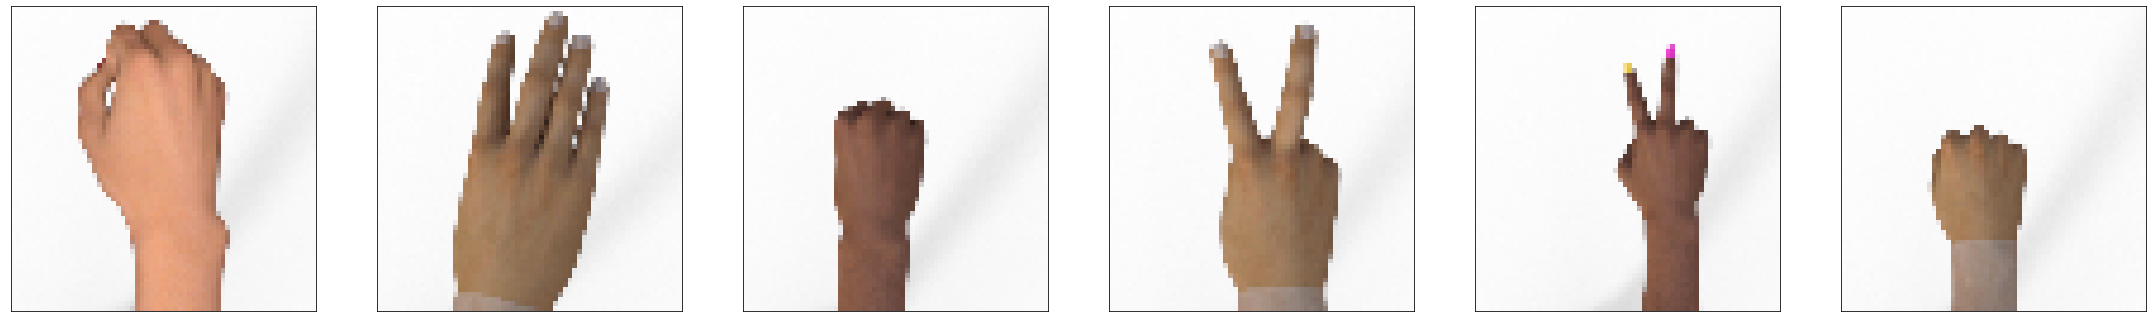

In [12]:
# Set the number of images to show:
nb_show = 6

# Define the class labels:
class_labels = np.asarray(a= hands_builder.info.features["label"].names)

# Create an iterable batch object of the images:
hands_dataset_iter = hands_dataset.batch(nb_show).skip(1).__iter__()
batch = next(hands_dataset_iter)

# Plot:
figure = plot_images_inGrid(images=[batch['image'].numpy()], transpose=True)
figure.show()

print("Image labels: {}".format(class_labels[batch['label'].numpy()]))

In [ ]:
break

In [ ]:
<img src="Description Images/.png" width="750">

Image Ref -> 